In [1]:
import numpy as np
import pandas as pd
from pysr import PySRRegressor
from IPython.display import HTML
from matplotlib import pyplot as plt

from hyperfit.linfit import LinFit

In [2]:
df = pd.read_csv('SMBH_Data_0407.csv',header=1)

In [13]:
## useful functions
def x2name(feature_list,df_handson):
    for ind in feature_list:
        i=int(ind[1:])
        print('x',i,':',df_handson.columns[i])

def df2name(df):
    for i in range(len(df.columns)):
        print('x',i,':',df.columns[i])
        
def test_relation(paras,obs=pd.read_csv('SMBH_Data_0303.csv',header=1),
                  operator='simp',ncyclesperiteration=550,niterations=40,denoise=False,adaptive_parsimony_scaling=20,
                  verbosity=0,colname=False):
    
    if paras[-1]!='M_BH':
        paras.append('M_BH')
        
    paras.append('M_BH_std')
    
    obs = obs[paras].dropna(axis='index',how='any')
    print(len(obs))
    
    
    y = obs['M_BH'].to_numpy()
    w = 1/obs['M_BH_std'].to_numpy()**2

    #df_handson = df
    if colname:
        X = obs.iloc[:,:-2]
    else:
        X = obs.iloc[:,:-2].to_numpy()
        #X = df_handson

    if operator=='adv':
        model = PySRRegressor(
            binary_operators=["+", "-", "*", "/","pow"],
            unary_operators=["exp","log10"],
            warm_start=False,
            denoise=denoise,
            niterations=niterations,
            ncyclesperiteration=ncyclesperiteration,
            adaptive_parsimony_scaling=adaptive_parsimony_scaling,
            verbosity=verbosity,
            precision=64,
        )
    if operator=='simp':
        model = PySRRegressor(
            binary_operators=["+", "-", "*", "/", "pow"],
            warm_start=False,
            denoise=denoise,
            niterations=niterations,
            ncyclesperiteration=ncyclesperiteration,
            adaptive_parsimony_scaling=adaptive_parsimony_scaling,
            verbosity=verbosity,
            precision=64,
        )
        
    if operator=='basic':
        model = PySRRegressor(
            binary_operators=["+", "-", "*", "/"],
            warm_start=False,
            denoise=denoise,
            niterations=niterations,
            ncyclesperiteration=ncyclesperiteration,
            adaptive_parsimony_scaling=adaptive_parsimony_scaling,
            verbosity=verbosity,
            precision=64,
        )



    model.fit(X=X, y=y, weights=w)

    print('parameters:')
    df2name(obs.iloc[:,:-2])
    
    print('Eq. selected rmse:',wrmse(y,model.predict(X),w))
    display(model.sympy())
    
    for i in range(len(model.equations_)):
        print('Eq.',i,'rmse:',wrmse(y,model.predict(X,index=i),w))
        display(model.sympy(index=i))

In [160]:
def rmse(y,y_pred):
    return np.sqrt(np.average((y-y_pred)**2))

def wrmse(y,y_pred,w):
    return np.sqrt(np.average((y-y_pred)**2,weights=w))

In [138]:
def scatter_residual(x, y, xerr, fmt, alpha, label, ax, ax_histx, bins=12):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    # the scatter plot:
    ax.errorbar(x,y,xerr=xerr,fmt=fmt,ecolor='grey',capsize=3, alpha=alpha,label=label)

    # x hist
    residual=y-x
    _,edges=np.histogram(x,bins)
    hist, _ = np.histogram(x, bins=edges, weights=residual)
    ax_histx.stairs(hist,edges,lw=3,alpha=alpha)

In [168]:
def plot_relation(paras,relation,obs=pd.read_csv('SMBH_Data_0303.csv',header=1),label='new relation',labelamp=0.8):
    if paras[-1]!='M_BH':
        paras.append('M_BH')
        
    paras.append('M_BH_std')
    
    offset=0
    if np.isin(paras,'log_sigma0').sum()==0:
        paras.append('log_sigma0')
        offset=1
    
    obs = obs[paras].dropna(axis='index',how='any')
    
    print(len(obs))
    
    y=obs['M_BH'].to_numpy()
    yerr=obs['M_BH_std'].to_numpy()
    
    x=[]
    for i in range(len(paras)-(2+offset)):
        x.append(obs.iloc[:,i].to_numpy())
    
    y_pred=relation(*x)
    
    
    # Start with a square Figure.
    fig = plt.figure(figsize=(12,10))
    fs=20
    bins=8
    # Add a gridspec
    gs = fig.add_gridspec(2, 1,  height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    # Draw the f(x)=x line
    minrange=np.array([y.min(),y_pred.min()]).min()
    maxrange=np.array([y.max(),y_pred.max()]).max()
    ax.plot(np.linspace(minrange,maxrange),np.linspace(minrange,maxrange),label='f(x)=x',c='r',ls='--')
    ax_histx.plot(np.linspace(minrange,maxrange),np.zeros(len(np.linspace(minrange,maxrange))),c='r',ls='--')
    # Draw the scatter plot and marginals.
    ## new relation
    scatter_residual(y,y_pred,yerr,'o',0.8,label,
                     ax, ax_histx,bins=bins)
    ## m-sigma relation
    y_pred_msigma=m_sigma_relation(obs['log_sigma0'])
    y_msigma=obs['M_BH']
    yerr_msigma=obs['M_BH_std']
    scatter_residual(y_msigma,y_pred_msigma,yerr_msigma,'s',0.5,r'$m-\sigma$ relation',
                    ax, ax_histx,bins=bins)
        
    ax.set_xlabel(r'True $\rm{log} M_{BH}[M_\odot]$',fontsize=fs)
    ax.set_ylabel(r'Predicted $\rm{log} M_{BH}[M_\odot]$',fontsize=fs)
    ax.legend(fontsize=fs*labelamp)
    plt.show()

    w = 1/yerr**2
    #print('obs rmse:',rmse(y,y_pred))
    print('new relation wrmse:',wrmse(y,y_pred,w))
    print('m-sigma wrmse:',wrmse(y_msigma,y_pred_msigma,1/yerr_msigma**2))

In [57]:
8.17-np.log10(200)*5.82

-5.221994574764372

In [65]:
def m_sigma_relation(log_sigma0):    
    a=5.82
    b=-5.221994574764372
    return a*(log_sigma0)+b

In [4]:
df.columns

Index(['ID', 'Galaxy', 'Morphology', 'Type', 'ETG', 'Leda Type', 'T-type',
       'T-type_std', 'Arm Class', 'Bar',
       ...
       'hic', 'hic_std', 'mabs', 'mabs_std', 'blum', 'blum_std', 'logblum',
       'logblum_std', 'Sigma_0', 'Sigma_0_std'],
      dtype='object', length=185)

In [5]:
df[['log_sigma0','M*_gal','phi','tan_phi','log_v_max','v_max']]

,log_sigma0,M*_gal,phi,tan_phi,log_v_max,v_max
0,2.490000,11.70,NaN,NaN,NaN,NaN
1,2.471453,11.69,NaN,NaN,1.544068,35.00
2,NaN,NaN,NaN,NaN,2.239350,173.52
3,2.515012,11.74,NaN,NaN,NaN,NaN
4,2.510679,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
140,2.198657,11.04,11.2,0.198005,NaN,NaN
141,NaN,11.13,9.1,0.160174,2.390935,246.00
142,2.073315,10.90,10.9,0.192570,2.301030,200.00
143,2.029384,10.68,10.4,0.183534,2.322219,210.00


$\phi\ $,$M^*_{gal}\ $,$\sigma\ $,$v_{max}$

In [6]:
test_relation(['log_sigma0','M*_gal','phi','tan_phi','log_v_max','v_max'],operator='basic')

37


/home/zj448/miniconda3/lib/python3.9/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


parameters:
x 0 : log_sigma0
x 1 : M*_gal
x 2 : phi
x 3 : tan_phi
x 4 : log_v_max
x 5 : v_max
Eq. selected rmse: 0.27451943911545185


(x0 + 1.3969453234456826)*(-x3 + x4)

Eq. 0 rmse: 0.5611299210807394


7.493157102122143

Eq. 1 rmse: 0.49440967840310124


0.6925368620312773*x1

Eq. 2 rmse: 0.3423783395222323


x4*(x0 + 1.050557207578478)

Eq. 3 rmse: 0.27451943911545185


(x0 + 1.3969453234456826)*(-x3 + x4)

Eq. 4 rmse: 0.2744641617780004


(x0 + 1.3969453234472307)*(-1.0035813163862486*x3 + x4)

Eq. 5 rmse: 0.272624809345695


-x3 + x4 + (x0 + 0.7705908697679895)*(-x3 + x4) - 0.7920788134404934

Eq. 6 rmse: 0.2723274321956629


-x3 + x4 + (x0 + 0.49872377075939317)*(-x3 + x4) - 44.5798075907555/(-x1 + x5)

Eq. 7 rmse: 0.2687761821051442


-x3 + x4 + (x0 + 0.3823478934263225)*(-x3 + x4) + 0.1871327186056487/(x2 - x4 - 1.4492015511657934)

Eq. 8 rmse: 0.25020191695672006


-x3 + x4 + (x0 + 0.45706776931612336)*(-x3 + x4) - 4.104425346489202/(-x2**2 - x2 + x5)

\begin{equation}
\log (\frac{{M}_{BH}}{{M}_\odot})= (\log \sigma_0 + 1.40)(\log v_{max} -\tan \phi))
\end{equation}

In [21]:
def sigma_phi_v_relation(log_sigma0,phi,v):    
    a=1.3969453234456826
    return (log_sigma0+a)*(v-phi)

41


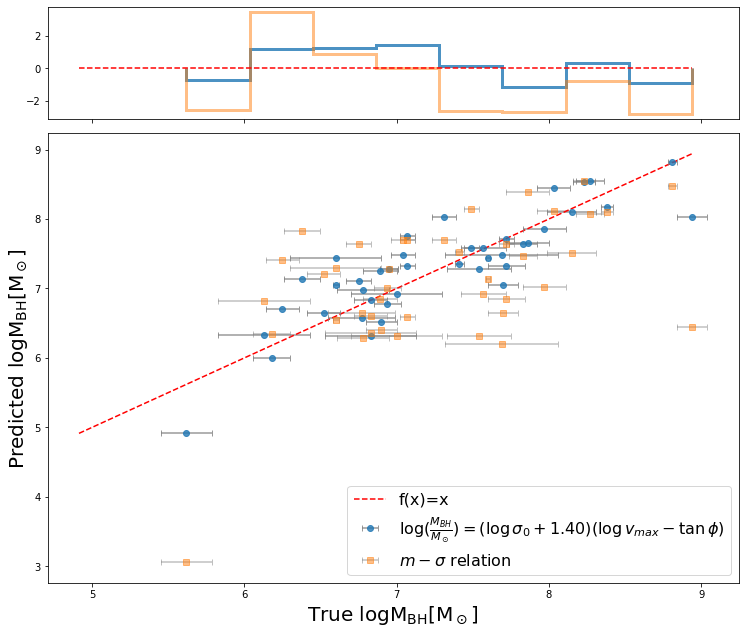

new relation wrmse: 0.27820990325942074
m-sigma wrmse: 0.4846167822437612


In [156]:
plot_relation(['log_sigma0','tan_phi','log_v_max'],sigma_phi_v_relation,label=r'$\log (\frac{{M}_{BH}}{{M}_\odot})= (\log \sigma_0 + 1.40)(\logv_{max}-\tan\phi)$')

$\phi\ $,$M^*_{gal}\ $,$\sigma\ $

In [24]:
test_relation(['log_sigma0','M*_gal','tan_phi'],operator='basic')

43


/home/zj448/miniconda3/lib/python3.9/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


parameters:
x 0 : log_sigma0
x 1 : M*_gal
x 2 : tan_phi
Eq. selected rmse: 0.3355362316523948


3.8894438058884226*x0 - 3.8894438058884226*x2

Eq. 0 rmse: 0.5725669294786132


7.46803044356267

Eq. 1 rmse: 0.40795524052949406


3.484506195586526*x0

Eq. 2 rmse: 0.3355362316523948


3.8894438058884226*x0 - 3.8894438058884226*x2

Eq. 3 rmse: 0.3224454821447261


x0*(-x0*x2 + 3.9604782963117207)

Eq. 4 rmse: 0.32218943606230055


x0*(-x0*(x2 + 0.06304386597277785) + 4.09618530655164)

Eq. 5 rmse: 0.30266373354544385


x0*(-x2*(x1 - 8.345741075751173) + 4.034336194515889)

Eq. 6 rmse: 0.29948522753810974


x0*(-0.17407732126568468*x1*x2 - x2 + 1.297173395423415 + 30.692667230922098/x1)

\begin{equation}
\log (\frac{{M}_{BH}}{{M}_\odot})= 3.89 (\log \sigma_0 - \tan\phi)
\end{equation}

In [49]:
def sigma_phi_relation(sigma,phi):
    a=3.8894438058884226
    b=-3.8894438058884226
    return a*sigma+b*phi

47


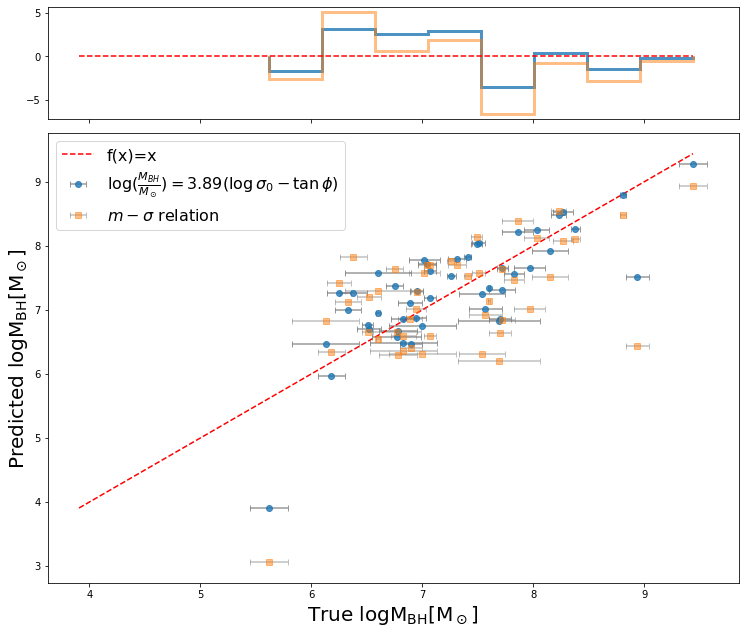

new relation wrmse: 0.340965900049914
m-sigma wrmse: 0.47929122301367655


In [157]:
plot_relation(['log_sigma0','tan_phi'],sigma_phi_relation,label=r'$\log (\frac{{M}_{BH}}{{M}_\odot})= 3.89 (\log \sigma_0 - \tan\phi)$')

$\phi\ $,$M^*_{gal}\ $,$v_{max}$

In [26]:
test_relation(['M*_gal','tan_phi','log_v_max'],operator='basic')

38


/home/zj448/miniconda3/lib/python3.9/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


parameters:
x 0 : M*_gal
x 1 : tan_phi
x 2 : log_v_max
Eq. selected rmse: 0.3194718615233394


1.514256269494091*x2*(-x1 + x2)

Eq. 0 rmse: 0.5610784215465191


7.493195672528427

Eq. 1 rmse: 0.4587883992166521


3.2059571742601576*x2

Eq. 2 rmse: 0.39687783839743423


1.3697599572249846*x2**2

Eq. 3 rmse: 0.3194718615233394


1.514256269494091*x2*(-x1 + x2)

Eq. 4 rmse: 0.3155163852031166


-x1 + 1.5570080701239617*x2*(-x1 + x2)

Eq. 5 rmse: 0.31089118721689796


-5.757437286235246*x1 + x2**2 + 3.3012747723850996

Eq. 6 rmse: 0.31057107198983325


x2**2 - (0.1833554762535017 - x1)*(x1 - 5.757437286235246) + 2.2456171167677677

Eq. 7 rmse: 0.3102243194500665


0.5428616943903293*x0*(0.1833554762535017 - x1) + x2**2 + 2.2456171167677677

Eq. 8 rmse: 0.30748002453058093


1.5681210104341428*x2*(x2 + x1*x2**2*(-x2 - 0.31120885552391886)/x0)

Eq. 9 rmse: 0.3073706792650127


1.5682476153784406*x2*(x2 + x1*x2**3*(-x0 - 1.4427768036100617)/x0**2)

\begin{equation}
\log (\frac{{M}_{BH}}{{M}_\odot})= 1.51 \log v_{max}(\log v_{max}-\tan\phi) 
\end{equation}

In [51]:
def phi_v_relation(phi,v):
    a=1.514256269494091
    return a*v*(v-phi)

41


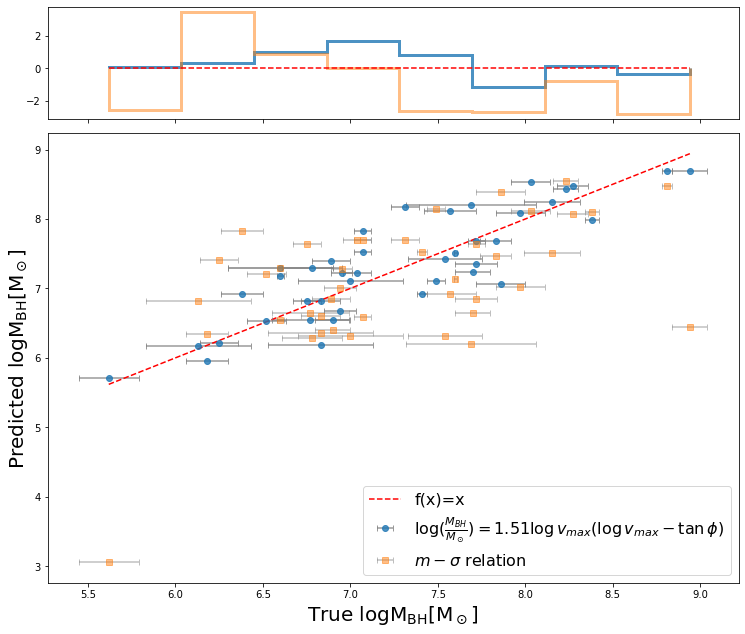

new relation wrmse: 0.321673533239793
m-sigma wrmse: 0.4846167822437612


In [158]:
plot_relation(['tan_phi','log_v_max'],phi_v_relation,label=r'$\log (\frac{{M}_{BH}}{{M}_\odot})= 1.51 \log v_{max}(\log v_{max}-\tan\phi) $')

$\phi\ $,$M^*_{gal}\ $

In [30]:
test_relation(['M*_gal','tan_phi'],operator='basic',ncyclesperiteration=5000,niterations=100)

44


/home/zj448/miniconda3/lib/python3.9/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


parameters:
x 0 : M*_gal
x 1 : tan_phi
Eq. selected rmse: 0.25342988968654245


(8.928946755726638 + 0.6121230044044399*x1/(x0*(x0 - 2.5005639649031903/x1)))/(x1 + 0.9796146336168521)

Eq. 0 rmse: 0.5725195522131183


7.46807109102445

Eq. 1 rmse: 0.49953630242875147


x0 - 3.3723325023486583

Eq. 2 rmse: 0.39857072757888345


9.204626369571669 - 7.723434501949809*x1

Eq. 3 rmse: 0.3942243174363315


(8.928946755726638 - x1)/(x1 + 0.9448563695074454)

Eq. 4 rmse: 0.39250810693254184


-x1*(-x0*x1 + 12.259519807501231) + 9.64890452878563

Eq. 5 rmse: 0.3924489195534112


-x1*(-x1*(x0 - x1) + 12.104907629481149) + 9.627357147921174

Eq. 6 rmse: 0.3923334876377802


-x1*(x1*(11.80161372160123 - 2*x0) + 11.80161372160123) + 9.607725548569336

Eq. 7 rmse: 0.3792674493111503


-x1*(7.803223456149768 + 4.225039488437807/(53.58762681153038 - 9.286831875186955/x1)) + 9.286831875186955

Eq. 8 rmse: 0.25342988968654245


(8.928946755726638 + 0.6121230044044399*x1/(x0*(x0 - 2.5005639649031903/x1)))/(x1 + 0.9796146336168521)

Eq. 9 rmse: 0.23798176740576768


(-0.1119952920940696*x1*(x0 - 0.5087265203084218/(x0 - 2.5005639649031903/x1)) + 8.928946755726638)/(x1 + 0.9452318819766803)

Eq. 10 rmse: 0.2367177160315066


(8.928946755726638 - x1*(x0 + 1.9694892053663577 - 0.6068381799828715/(x0 - 2.5005639649031903/x1))/x0)/(x1 + 0.9471348949785378)

\begin{equation}
\log (\frac{{M}_{BH}}{{M}_\odot})= \frac{8.93+\frac{0.61 \tan\phi}{M^*_{gal}(M^*_{gal}-\frac{2.50}{\tan\phi})}}{\tan\phi+0.98}
\end{equation}

In [53]:
def mgal_phi_relation(mgal,phi):
    a=8.928946755726638
    b=0.6121230044044399
    c=2.5005639649031903
    d=0.9796146336168521
    return (a+(b*phi/(mgal*(mgal-(c/phi)))))/(phi+d)

43


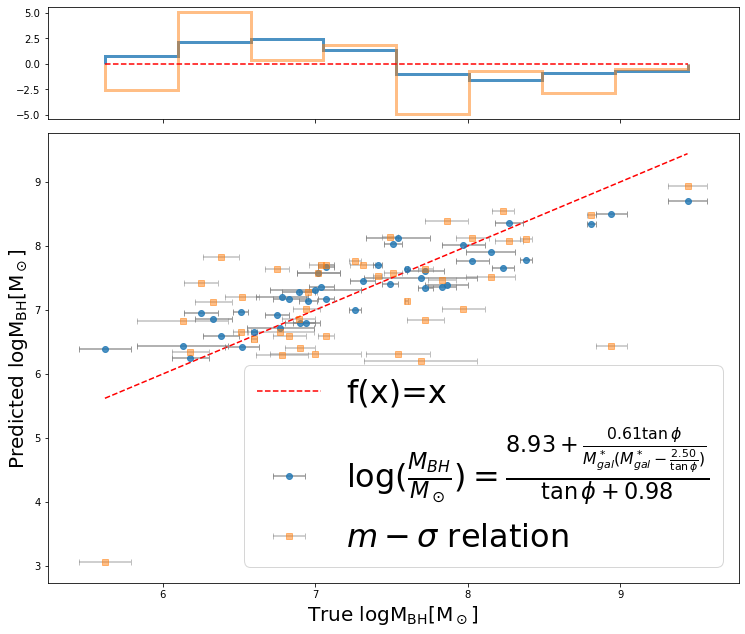

new relation wrmse: 0.25344543440950185
m-sigma wrmse: 0.47431741758670204


In [169]:
plot_relation(['M*_gal','tan_phi'],mgal_phi_relation,labelamp=1.6,label=r'$\log (\frac{{M}_{BH}}{{M}_\odot})= \frac{8.93+\frac{0.61 \tan\phi}{M^*_{gal}(M^*_{gal}-\frac{2.50}{\tan\phi})}}{\tan\phi+0.98}$')